# Homework Starter — Stage 10b: Time Series & Classification
Fill in the TODOs. Use your own dataset or adapt the synthetic generator below.

In [5]:
# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import mean_absolute_error, mean_squared_error, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, TimeSeriesSplit
np.random.seed(7); sns.set(); plt.rcParams['figure.figsize']=(9,4)

## Option A: Use Your Own Data (Recommended)
Load your data here (ensure a DateTime index for time series).

In [ ]:
# TODO: load your data
df = pd.read_csv('/Users/aditya/Documents/bootcamp_aditya_shah/homework/stage10b_time_series/data/synthetic_stock_data.csv', parse_dates=['date'], index_col='date')

## Feature Engineering

In [15]:
# TODO: create at least two features
df['lag_1'] = df['ret'].shift(1)
df['roll_mean_5'] = df['ret'].rolling(5).mean().shift(1)
# Add your own:
# Rolling volatility (20-day lookback, shifted)
df['roll_vol_20'] = df['ret'].rolling(20).std().shift(1)

# Momentum: cumulative return over the past 10 days
df['momentum_10'] = df['ret'].rolling(10).sum().shift(1)

# Exponentially weighted moving average (trend indicator)
df['ewm_10'] = df['ret'].ewm(span=10, adjust=False).mean().shift(1)


df['y_next_ret'] = df['ret'].shift(-1)
df['y_up'] = (df['y_next_ret']>0).astype(int)
df_feat = df.dropna().copy()
df_feat.head()

,price,ret,log_ret,lag_1,roll_mean_5,roll_vol_20,momentum_10,ewm_10,y_next_ret,y_up
date,,,,,,,,,,
2020-01-29,98.678487,0.015069,0.014956,-0.013728,-0.006822,0.009467,-0.075522,-0.006577,-0.001956,0
2020-01-30,98.485487,-0.001956,-0.001958,0.015069,-0.002747,0.010177,-0.056129,-0.002641,0.000976,1
2020-01-31,98.581585,0.000976,0.000975,-0.001956,-0.001182,0.010180,-0.053737,-0.002517,-0.013851,0
2020-02-03,97.216164,-0.013851,-0.013947,0.000976,-0.001676,0.010030,-0.055484,-0.001882,-0.005131,0
2020-02-04,96.717385,-0.005131,-0.005144,-0.013851,-0.002698,0.009578,-0.050678,-0.004058,0.001410,1


## Split

In [16]:
# Time-aware split
cut=int(len(df_feat)*0.8)
train, test = df_feat.iloc[:cut], df_feat.iloc[cut:]
features=['lag_1','roll_mean_5','roll_vol_20','momentum_10','ewm_10']  # extend as you add features
X_tr, X_te = train[features], test[features]
y_tr_reg, y_te_reg = train['y_next_ret'], test['y_next_ret']
y_tr_clf, y_te_clf = train['y_up'], test['y_up']

## Pipeline + Model (Choose one track below)

              precision    recall  f1-score   support

           0       0.50      0.39      0.44        62
           1       0.44      0.56      0.49        54

    accuracy                           0.47       116
   macro avg       0.47      0.47      0.46       116
weighted avg       0.47      0.47      0.46       116



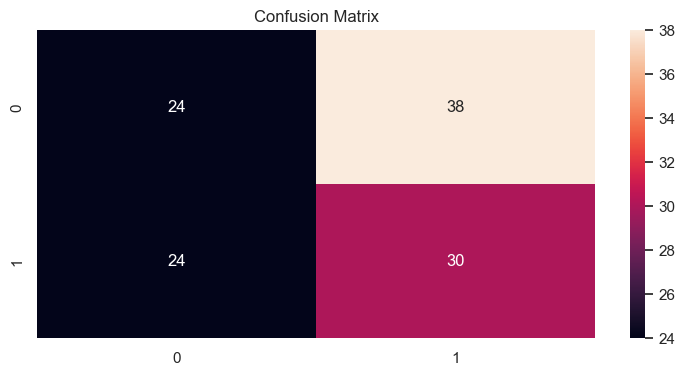

In [18]:
# Track 2: Classification (up/down)
clf = Pipeline([('scaler', StandardScaler()), ('logit', LogisticRegression(max_iter=1000))])
clf.fit(X_tr, y_tr_clf)
predc = clf.predict(X_te)
print(classification_report(y_te_clf, predc))
cm = confusion_matrix(y_te_clf, predc)
sns.heatmap(cm, annot=True, fmt='d'); plt.title('Confusion Matrix'); plt.show()

## Interpretation

- **What worked:**  
  - Pipeline with scaling + logistic regression runs fine.  
  - Features (lags, rolling mean, volatility, momentum, EWM) capture short-term patterns.  
  - Classification target (`y_up`) is well-defined.  

- **Where assumptions may fail:**  
  - Logistic regression assumes linear separability; markets are noisy.  
  - Returns are non-stationary → fixed windows may not adapt.  
  - Class imbalance possible (model favors "up").  
  - Ignores temporal dependence (treats rows as independent).  

- **How to extend:**  
  - Add longer-window features & technical indicators (RSI, MACD, Bollinger Bands).  
  - Include multiple lags (2, 5, 10).  
  - Try tree-based models (Random Forest, XGBoost) for nonlinear patterns.  
  - Use `TimeSeriesSplit` for CV to avoid look-ahead bias.  


### Save Notebook
Remember to save as `notebooks/modeling_<team>.ipynb`.